# Notebook 02: Classificação Funcional via GNN (Imputação de Lacunas)

# 2. Imputação de Classes Funcionais com Redes Neurais em Grafos (GNN)
**Projeto:** Acessibilidade UBS Teresina
**Autor:** Felipe Ramos Dantas
**Data:** 06/02/2026

## Objetivo
Este notebook aborda o problema das vias sem classificação definida (*unknown* ou *unclassified*) na malha viária. Utiliza-se uma abordagem de **Aprendizado Transdutivo** em Grafos (GNN) para predizer a função da via baseando-se em:
1. **Atributos Geométricos:** Comprimento e linearidade (tortuosidade).
2. **Atributos Físicos:** Tipo de superfície (pavimentado/não pavimentado).
3. **Contexto Topológico:** A classificação das vias vizinhas (Grafo Dual).

O resultado final é uma malha viária com a coluna `class_final` preenchida, pronta para a atribuição de velocidades.

In [1]:
# Core libraries
import os
import numpy as np
import itertools
import pandas as pd

# urbanity for classification graph analysis
import urbanity as urb
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv # A camada de Rede Neural de Grafos
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# Graph analysis
import city2graph as c2g
import networkx as nx

# Geospatial libraries
import geopandas as gpd
from shapely.geometry import Point


# Plot libraries
import matplotlib.pyplot as plt

# Configure matplotlib for high-quality visualizations
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.style.use('ggplot')

# Configuração de Caminhos
OUTPUT_PATH = "../dados/processados/overturemaps/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Definição de Dispositivo (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Ambiente configurado. Rodando em: {device}")

Ambiente configurado. Rodando em: cpu


## 1. Carregando dados originais

In [4]:
# Load the downloaded GeoJSON files
#buildings_gdf = gpd.read_file("../dados/brutos/overturemaps/teresina_bbox_building.geojson")
segments_gdf = gpd.read_file("../dados/brutos/overturemaps/teresina_bbox_segment.geojson") 
connectors_gdf = gpd.read_file("../dados/brutos/overturemaps/teresina_bbox_connector.geojson")

# Convertendo para Sistema de Referência Ofical do Brasil: SIRGAS 2000; Reprojetando para
#  UTM Zona 23 Sul 
# Convert to British National Grid (EPSG:27700) for accurate distance calculations
#buildings_gdf = buildings_gdf.to_crs(epsg=31983)
segments_gdf = segments_gdf.to_crs(epsg=31983)
connectors_gdf = connectors_gdf.to_crs(epsg=31983)

print("✅ Data loaded successfully!")
print("📊 Dataset summary:")
#print(f"   • Buildings: {len(buildings_gdf):,}")
print(f"   • Road segments: {len(segments_gdf):,}")
print(f"   • Connectors: {len(connectors_gdf):,}")
print(f"   • CRS: {segments_gdf.crs}")

✅ Data loaded successfully!
📊 Dataset summary:
   • Road segments: 66,486
   • Connectors: 49,664
   • CRS: EPSG:31983


In [5]:
segments_gdf.columns.tolist()

['id',
 'version',
 'sources',
 'subtype',
 'class',
 'names',
 'connectors',
 'routes',
 'subclass_rules',
 'access_restrictions',
 'level_rules',
 'destinations',
 'prohibited_transitions',
 'rail_flags',
 'road_surface',
 'road_flags',
 'speed_limits',
 'width_rules',
 'subclass',
 'geometry']

## 2 Limpeza dos dados

### 2.1 Manter apenas as estradas/rodovias/ruas (road)

In [4]:
# Define qual coluna queremos analisar
coluna_alvo = 'subtype'

if coluna_alvo in segments_gdf.columns:
    print(f"\n--- Distribuição de Trechos por Tipo ('{coluna_alvo}') ---")
    
    # value_counts(dropna=False) conta inclusive os nulos (se houver)
    # O resultado já vem ordenado do maior para o menor
    contagem = segments_gdf[coluna_alvo].value_counts(dropna=False)
    total_segmentos = len(segments_gdf)

    # Iterar sobre a série para imprimir formatado
    for classe, qtd in contagem.items():
        percentual = (qtd / total_segmentos) * 100
        # O :<20 garante alinhamento do texto à esquerda
        print(f"  • {str(classe):<20}: {qtd:,} trechos ({percentual:.1f}%)")
        
    print(f"\nTotal de Segmentos: {total_segmentos:,}")

else:
    print(f"Erro: A coluna '{coluna_alvo}' não existe no DataFrame.")


--- Distribuição de Trechos por Tipo ('subtype') ---
  • road                : 66,444 trechos (99.9%)
  • rail                : 41 trechos (0.1%)
  • water               : 1 trechos (0.0%)

Total de Segmentos: 66,486


In [5]:
# Verificamos o que tem antes
print("Coluna 'Subtype' antes do filtro:", segments_gdf['subtype'].unique())
print(f"Total de tipo de vias: {len(segments_gdf)}\n")

# Filter to keep only road segments (excluding rail, water, etc.)
road_gdf = segments_gdf[segments_gdf["subtype"] == "road"].copy()

print("Coluna 'Subtype' depois do filtro:", road_gdf['subtype'].unique())
print(f"Total de tipo de vias: {len(road_gdf)}")

print(f"Foram removidos {len(segments_gdf)-len(road_gdf)} ({((len(segments_gdf)-len(road_gdf))/len(segments_gdf))*100:.2f}%) segmentos diferentes de 'road'")

Coluna 'Subtype' antes do filtro: ['road' 'rail' 'water']
Total de tipo de vias: 66486

Coluna 'Subtype' depois do filtro: ['road']
Total de tipo de vias: 66444
Foram removidos 42 (0.06%) segmentos diferentes de 'road'


### 2.2 Classes das vias

In [6]:
# Define qual coluna queremos analisar
coluna_alvo = 'class'

if coluna_alvo in road_gdf.columns:
    print(f"\n--- Distribuição de Trechos por Classe ('{coluna_alvo}') ---")
    
    # value_counts(dropna=False) conta inclusive os nulos (se houver)
    # O resultado já vem ordenado do maior para o menor
    contagem = road_gdf[coluna_alvo].value_counts(dropna=False)
    total_segmentos = len(road_gdf)

    # Iterar sobre a série para imprimir formatado
    for classe, qtd in contagem.items():
        percentual = (qtd / total_segmentos) * 100
        # O :<20 garante alinhamento do texto à esquerda
        print(f"  • {str(classe):<20}: {qtd:,} trechos ({percentual:.1f}%)")
        
    print(f"\nTotal de Segmentos: {total_segmentos:,}")

else:
    print(f"Erro: A coluna '{coluna_alvo}' não existe no DataFrame.")


--- Distribuição de Trechos por Classe ('class') ---
  • residential         : 44,092 trechos (66.4%)
  • tertiary            : 5,051 trechos (7.6%)
  • unclassified        : 4,926 trechos (7.4%)
  • secondary           : 3,436 trechos (5.2%)
  • service             : 2,835 trechos (4.3%)
  • primary             : 2,571 trechos (3.9%)
  • trunk               : 845 trechos (1.3%)
  • living_street       : 662 trechos (1.0%)
  • path                : 527 trechos (0.8%)
  • unknown             : 506 trechos (0.8%)
  • footway             : 499 trechos (0.8%)
  • track               : 415 trechos (0.6%)
  • cycleway            : 29 trechos (0.0%)
  • pedestrian          : 26 trechos (0.0%)
  • steps               : 24 trechos (0.0%)

Total de Segmentos: 66,444


In [7]:
# Tiramos uma cópia segura dos dados antes de qualquer IA mexer neles
#
# road_gdf['classe_original'] = road_gdf['class'].fillna('unclassified').copy()
road_gdf['classe_original'] = road_gdf['class'].copy()

In [8]:
# 2. Criar Features Geométricas (O que define a rua?)
print("Criando características geométricas...")

# A) Comprimento Normalizado
road_gdf['length'] = road_gdf.geometry.length

# B) Linearidade (Reta vs Curva)
def get_linearity(geom):
    try:
        dist = Point(geom.coords[0]).distance(Point(geom.coords[-1]))
        return dist / geom.length if geom.length > 0 else 0
    except:
        return 0
        
road_gdf['linearity'] = road_gdf.geometry.apply(get_linearity)

Criando características geométricas...


In [9]:
road_gdf.columns

Index(['id', 'version', 'sources', 'subtype', 'class', 'names', 'connectors',
       'routes', 'subclass_rules', 'access_restrictions', 'level_rules',
       'destinations', 'prohibited_transitions', 'rail_flags', 'road_surface',
       'road_flags', 'speed_limits', 'width_rules', 'subclass', 'geometry',
       'classe_original', 'length', 'linearity'],
      dtype='object')

In [10]:
road_gdf.head(3)

,id,version,sources,subtype,class,names,connectors,routes,subclass_rules,access_restrictions,...,rail_flags,road_surface,road_flags,speed_limits,width_rules,subclass,geometry,classe_original,length,linearity
0,6d775c41-5cf2-493e-b402-cfcbd8972262,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,unclassified,None,[{'connector_id': 'eaaeee83-1ec8-4c2f-a46e-dde...,None,None,None,...,None,"[{'value': 'unpaved', 'between': None}]",None,None,None,None,"LINESTRING (723376.977 9408354.072, 723403.887...",unclassified,720.449364,0.973612
1,aec4047f-e9b3-4c2b-ba48-c1c065ffc97e,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,unclassified,None,[{'connector_id': '89a3c9a6-e65e-4102-888f-499...,None,None,None,...,None,"[{'value': 'unpaved', 'between': None}]",None,None,None,None,"LINESTRING (724465.971 9415641.369, 724036.799...",unclassified,2081.823556,0.999003
2,fabe85df-cfbc-4adc-a6e7-7a41c44f39c6,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,unclassified,None,[{'connector_id': 'c32213b5-fe58-4ca9-a910-32a...,None,None,None,...,None,"[{'value': 'unpaved', 'between': None}]",None,None,None,None,"LINESTRING (723945.476 9414665.026, 723870.213...",unclassified,1099.216268,0.968581


## 2.3 Extração de Atributos em LIST ou DICT

### 2.3.1 Extraindo o nome das vias

In [11]:
# 1. Função para extrair o nome da via da coluna 'names'
# Estrutura esperada: [{'primary': 'Av. Frei Serafim', 'common': ..., 'rules': ...}]
def extrair_nome_via(valor_celula):
    try:
        # Se for nulo, vazio ou NaN
        if valor_celula is None:
            return None
        
        dado_alvo = valor_celula
        
        # Agora esperamos que 'dado_alvo' seja um dicionário
        if isinstance(dado_alvo, dict):
            # Tenta pegar a chave 'primary'. Se não existir, retorna None.
            return dado_alvo.get('primary', None)
            
        # Caso residual (se for string direta, retorna ela mesma)
        return str(valor_celula)
        
    except Exception:
        return None

# 2. Aplicar a extração
print("Extraindo nomes das vias (Formato Legível)...")

# Cria uma coluna limpa 'name_clean'
# Nota: Recomendo não sobrescrever 'names' ainda caso precise consultar os outros metadados depois
road_gdf['nomes_vias'] = road_gdf['names'].apply(extrair_nome_via)

# 3. Verificação (Amostra para garantir que funcionou)
print("\n--- Amostra de Nomes Extraídos ---")
# Filtra apenas quem tem nome para visualizar melhor
amostra = road_gdf[road_gdf['nomes_vias'].notnull()][['names', 'nomes_vias']].head(5)
print(amostra)

Extraindo nomes das vias (Formato Legível)...

--- Amostra de Nomes Extraídos ---
                                                 names              nomes_vias
111  {'primary': 'Estrada para Parnarama', 'common'...  Estrada para Parnarama
112  {'primary': 'Estrada para Parnarama', 'common'...  Estrada para Parnarama
131  {'primary': 'Estrada para Parnarama', 'common'...  Estrada para Parnarama
133  {'primary': 'Estrada para Parnarama', 'common'...  Estrada para Parnarama
134  {'primary': 'Estrada para Parnarama', 'common'...  Estrada para Parnarama


### 2.3.2 Extraindo a classificação da superfície das vias

In [12]:
# 1. Função para extrair valor de 'road_surface'
# Estrutura esperada: [{'between': null, 'value': 'paved'}]
def extrair_superficie(valor_celula):
    try:
        # Se for nulo ou lista vazia
        if valor_celula is None or len(valor_celula) == 0:
            return 'unknown'
        
        # Se for uma lista (padrão Overture), pega o primeiro item
        if isinstance(valor_celula, list):
            primeiro_item = valor_celula[0]
            if isinstance(primeiro_item, dict):
                return primeiro_item.get('value', 'unknown')
        
        # Caso venha como string direta (raro, mas possível)
        return str(valor_celula)
    except:
        return 'unknown'

# 2. Aplicar a extração
print("Extraindo informações de superfície...")
# Cria uma coluna limpa 'surface_clean'
road_gdf['surface_clean'] = road_gdf['road_surface'].apply(extrair_superficie)

Extraindo informações de superfície...


## 3. Transformação em Tensores PyTorch

--- Distribuição de Trechos por Classe ('class') ---
  • residential         : 44,092 trechos (66.4%)
  • tertiary            : 5,051 trechos (7.6%)
  • unclassified        : 4,926 trechos (7.4%)
  • secondary           : 3,436 trechos (5.2%)
  • service             : 2,835 trechos (4.3%)
  • primary             : 2,571 trechos (3.9%)
  • trunk               : 845 trechos (1.3%)
  • living_street       : 662 trechos (1.0%)
  • path                : 527 trechos (0.8%)
  • unknown             : 506 trechos (0.8%)
  • footway             : 499 trechos (0.8%)
  • track               : 415 trechos (0.6%)
  • cycleway            : 29 trechos (0.0%)
  • pedestrian          : 26 trechos (0.0%)
  • steps               : 24 trechos (0.0%)

Total de Segmentos: 66,444

In [13]:
print("Codificando features híbridas (Geometria + Superfície)...")

# 1. Preparar Rótulos (Target - O que queremos descobrir)
# (Mantemos a mesma lógica de antes)
classes_validas = [
    'motorway', 'trunk', 'primary', 'secondary', 'tertiary', 
    'residential', 'living_street', 'service', 'pedestrian', 'footway', 'step', 'path',
    'track' # Adicionei track pois superfície ajuda muito aqui
]

le = LabelEncoder()
le.fit(classes_validas)

def encode_target(val):
    if val in classes_validas:
        return le.transform([val])[0]
    return -1

road_gdf['y_encoded'] = road_gdf['class'].apply(encode_target)

Codificando features híbridas (Geometria + Superfície)...


In [14]:
le.classes_

array(['footway', 'living_street', 'motorway', 'path', 'pedestrian',
       'primary', 'residential', 'secondary', 'service', 'step',
       'tertiary', 'track', 'trunk'], dtype='<U13')

In [15]:
# 2. Preparar FEATURES (O X da questão)

# Parte A: Numéricas (Geometria)
# Normalizamos para que o comprimento (ex: 500m) não "engula" a linearidade (0 a 1)
features_numericas = road_gdf[['length', 'linearity']].values
scaler = StandardScaler()
X_num = scaler.fit_transform(features_numericas)

# Parte B: Categóricas (Superfície)
# Transforma 'paved' em [1, 0] e 'unpaved' em [0, 1]
encoder_surf = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
surface_data = road_gdf[['surface_clean']].values
X_cat = encoder_surf.fit_transform(surface_data)

print(f"Features de Superfície geradas: {encoder_surf.get_feature_names_out(['surface_clean'])}\n")

# Parte C: Combinação (Concatenação)
# Juntamos Geometria + Superfície numa matriz só
X_final = np.hstack([X_num, X_cat])

# Converte para Tensor PyTorch
x = torch.tensor(X_final, dtype=torch.float)

print(f"Dimensão final das Features (Input): {x.shape[1]} colunas")
# Guarde esse número! (x.shape[1]). Precisaremos dele na definição do Modelo.

Features de Superfície geradas: ['surface_clean_dirt' 'surface_clean_gravel' 'surface_clean_paved'
 'surface_clean_paving_stones' 'surface_clean_unknown'
 'surface_clean_unpaved']

Dimensão final das Features (Input): 8 colunas


In [16]:
# 3. GRAFO DUAL (A Grande Mudança)
# Passo A: Gera o Primal limpo pelo City2Graph
G_primal = c2g.morphology.segments_to_graph(road_gdf, multigraph=True)

In [17]:
G_primal[1][10:15]


id  \
from_node_id to_node_id edge_key                                         
7            6          0         499857f1-f179-44b6-8f3d-bbc4ba994e10   
8            41380      0         01a9d1da-823c-48ee-a4dc-84d6a32748f3   
9            41381      0         daf38249-b9f4-413d-8963-56e8669983b5   
10           9          0         b87e6cb4-4cab-4916-8817-f4cb59d85597   
             41382      0         4711a6cf-e0e3-4a2b-b5b9-168dcc211872   

                                  version  \
from_node_id to_node_id edge_key            
7            6          0               1   
8            41380      0               1   
9            41381      0               1   
10           9          0               1   
             41382      0               1   

                                                                            sources  \
from_node_id to_node_id edge_key                                                      
7            6          0         [{'property': '', 'dataset': 'OpenStreetMap', ...   
8            41380      0         [{'property': '', 'dataset': 'OpenStreetMap', ...   
9            41381      0         [{'property': '', 'dataset': 'OpenStreetMap', ...   
10           9          0         [{'property': '', 'dataset': 'OpenStreetMap', ...   
             41382      0         [{'property': '', 'dataset': 'OpenStreetMap', ...   

                                 subtype         class names  \
from_node_id to_node_id edge_key                               
7            6          0           road  unclassified  None   
8            41380      0           road  unclassified  None   
9            41381      0           road  unclassified  None   
10           9          0           road  unclassified  None   
             41382      0           road  unclassified  None   

                                                                         connectors  \
from_node_id to_node_id edge_key                                                      
7            6          0         [{'connector_id': '77c23dee-f301-465e-a04d-faa...   
8            41380      0         [{'connector_id': '33bd6442-baef-4a96-a17d-aae...   
9            41381      0         [{'connector_id': 'bc193007-0b96-4c97-821c-e05...   
10           9          0         [{'connector_id': '940fd179-f4d1-4e32-bf06-34f...   
             41382      0         [{'connector_id': '940fd179-f4d1-4e32-bf06-34f...   

                                 routes subclass_rules access_restrictions  \
from_node_id to_node_id edge_key                                             
7            6          0          None           None                None   
8            41380      0          None           None                None   
9            41381      0          None           None                None   
10           9          0          None           None                None   
             41382      0          None           None                None   

                                  ... speed_limits width_rules subclass  \
from_node_id to_node_id edge_key  ...                                     
7            6          0         ...         None        None     None   
8            41380      0         ...         None        None     None   
9            41381      0         ...         None        None     None   
10           9          0         ...         None        None     None   
             41382      0         ...         None        None     None   

                                                                           geometry  \
from_node_id to_node_id edge_key                                                      
7            6          0         LINESTRING (725657.249 9416851.421, 725620.192...   
8            41380      0         LINESTRING (728399.102 9416979.435, 728468.472...   
9            41381      0         LINESTRING (728037.849 9415477.588, 728022.693...   
10           9          0         LINESTRING (728544.285

In [18]:
G_primal[0][10:15]


,geometry
node_id,
10,POINT (728544.285 9415739.84)
11,POINT (730688.558 9415572.122)
12,POINT (729086.843 9415769.508)
13,POINT (729345.052 9415788.151)
14,POINT (729353.424 9415801.706)


In [19]:
# Passo B: Converte para Dual (Nós = Ruas)
# IMPORTANTE: O Dual do city2graph define os nós como tuplas de arestas ou IDs.
G_dual = c2g.utils.dual_graph(G_primal,  as_nx=True)

Removed 1 invalid geometries


In [20]:
# 1. VALIDAÇÃO DE ALINHAMENTO (Segurança Metodológica)
# O número de nós no grafo dual deve ser igual ao número de linhas no DataFrame
num_nos_dual = G_dual.number_of_nodes()
num_ruas_df = len(road_gdf)
print(f"Nós no Grafo Dual: {num_nos_dual}")
print(f"Ruas no DataFrame: {num_ruas_df}")

if num_nos_dual != num_ruas_df:
    print("⚠️ AVISO CRÍTICO: O número de nós não bate com o número de ruas.")
    print("Isso pode acontecer se o City2Graph fundiu segmentos ou removeu ilhas.")
    print("Atenção: O alinhamento das features pode estar comprometido se não tratarmos os IDs.")
    # Se isso acontecer, teríamos que filtrar o gdf_road para conter apenas os IDs presentes no grafo.

Nós no Grafo Dual: 66444
Ruas no DataFrame: 66444


In [21]:
# 2. CONVERSÃO DO GRAFO DUAL PARA TENSOR (Edge Index)
# Ordenamos por 'sorted' para garantir que o Nó ID 0 seja o menor índice, o Nó ID 1 o segundo, etc.
# Isso alinha com o DataFrame se os índices forem sequenciais.
# Passo A: Ordenar os nós para garantir alinhamento com o DataFrame (0, 1, 2...)
# Isso cria um grafo novo onde os nós são inteiros sequenciais
G_ordenado = nx.convert_node_labels_to_integers(G_dual, ordering='sorted')

In [22]:
# Passo B: Limpeza de Atributos (A CORREÇÃO DO ERRO)
# Criamos um grafo vazio e adicionamos APENAS a estrutura (arestas).
# Ignoramos propositalmente os atributos de geometria que causavam o crash.
G_topology_only = nx.Graph()
G_topology_only.add_nodes_from(G_ordenado.nodes()) # Adiciona nós (0..66443) sem dados
G_topology_only.add_edges_from(G_ordenado.edges()) # Adiciona conexões

print("Convertendo topologia limpa para Tensor...")
# Agora o from_networkx não vai encontrar 'lixo' para tentar converter
pyg_graph = from_networkx(G_topology_only)
edge_index = pyg_graph.edge_index


Convertendo topologia limpa para Tensor...


In [23]:
# 3. MÁSCARAS E OBJETO FINAL
# (Mantemos a lógica original)
y = torch.tensor(road_gdf['y_encoded'].values, dtype=torch.long)
train_mask = y != -1
predict_mask = y == -1

# Montagem final
# x vem das células anteriores (certifique-se que 'x' está na memória)
data = Data(x=x, edge_index=edge_index, y=y)
data.train_mask = train_mask
data.predict_mask = predict_mask

print("-" * 40)
print("OBJETO 'data' PRONTO PARA A GNN!")
print(f"Features: {data.num_node_features}")
print(f"Classes: {len(classes_validas)}")
print("-" * 70)
print("\nDados prontos! O modelo agora enxerga geometria E tipo de piso.")
print("-" * 70)

----------------------------------------
OBJETO 'data' PRONTO PARA A GNN!
Features: 8
Classes: 13
----------------------------------------------------------------------

Dados prontos! O modelo agora enxerga geometria E tipo de piso.
----------------------------------------------------------------------


## Definição e Treinamento do Modelo

### Célula: Estatísticas Comparativas (Validação do Modelo)

In [ ]:
# Célula: Grid Search para Seleção Estatística de Hiperparâmetros


print("Iniciando Grid Search para validação estatística...")

# 1. PREPARAÇÃO DOS DADOS (Hold-out Validation)
# Só podemos validar usando dados que SABEMOS a resposta (y != -1)
indices_conhecidos = (data.y != -1).nonzero(as_tuple=True)[0].cpu().numpy()
labels_conhecidos = data.y[indices_conhecidos].cpu().numpy()

# Dividimos estatisticamente: 80% para a IA aprender, 20% para a gente aplicar a "prova"
# O parâmetro 'stratify' garante que mantemos a proporção das classes (não pega só ruas residenciais, por exemplo)
idx_train, idx_val = train_test_split(
    indices_conhecidos, 
    test_size=0.20, 
    random_state=42, 
    stratify=labels_conhecidos
)

# Criamos máscaras temporárias para o teste
train_mask_search = torch.zeros_like(data.y, dtype=torch.bool)
train_mask_search[idx_train] = True

val_mask_search = torch.zeros_like(data.y, dtype=torch.bool)
val_mask_search[idx_val] = True

# 2. DEFINIÇÃO DO ESPAÇO DE BUSCA (As opções que vamos testar)
param_grid = {
    'hidden_channels': [16, 32, 64], # Tamanho do cérebro
    'lr': [0.01, 0.005],             # Velocidade de aprendizado
    'weight_decay': [5e-4, 1e-4],    # Penalidade (Regularização)
    'epochs': [200]                  # Fixo para comparar igual
}

# Gera todas as combinações possíveis (Produto Cartesiano)
keys, values = zip(*param_grid.items())
combinacoes = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Total de combinações a testar: {len(combinacoes)}")

# 3. LOOP DE TESTE
resultados = []

for params in combinacoes:
    # Reinicia o modelo do zero para cada teste
    model = StreetClassifier(
        num_features=data.num_node_features, 
        num_classes=len(classes_validas)
    ).to(device)
    
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=params['lr'], 
        weight_decay=params['weight_decay']
    )
    
    # Treino Rápido
    model.train()
    for epoch in range(params['epochs']):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[train_mask_search], data.y[train_mask_search])
        loss.backward()
        optimizer.step()
        
    # Validação (A "Prova")
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        # Comparar predição com gabarito APENAS no conjunto de validação
        correct = (pred[val_mask_search] == data.y[val_mask_search]).sum()
        acc = int(correct) / int(val_mask_search.sum())
    
    # Salva o resultado
    res = params.copy()
    res['accuracy'] = acc
    resultados.append(res)
    print(f"Teste {params}: Acurácia = {acc:.4f}")

# 4. MELHOR RESULTADO
df_results = pd.DataFrame(resultados)
melhor_config = df_results.loc[df_results['accuracy'].idxmax()]

print("\n--- VENCEDOR ESTATÍSTICO ---")
print(melhor_config)
print("----------------------------")

Iniciando Grid Search para validação estatística...
Total de combinações a testar: 12
Teste {'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.0005, 'epochs': 200}: Acurácia = 0.7364
Teste {'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.0001, 'epochs': 200}: Acurácia = 0.7387
Teste {'hidden_channels': 16, 'lr': 0.005, 'weight_decay': 0.0005, 'epochs': 200}: Acurácia = 0.7346
Teste {'hidden_channels': 16, 'lr': 0.005, 'weight_decay': 0.0001, 'epochs': 200}: Acurácia = 0.7357
Teste {'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.0005, 'epochs': 200}: Acurácia = 0.7358
Teste {'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.0001, 'epochs': 200}: Acurácia = 0.7375
Teste {'hidden_channels': 32, 'lr': 0.005, 'weight_decay': 0.0005, 'epochs': 200}: Acurácia = 0.7348
Teste {'hidden_channels': 32, 'lr': 0.005, 'weight_decay': 0.0001, 'epochs': 200}: Acurácia = 0.7360
Teste {'hidden_channels': 64, 'lr': 0.01, 'weight_decay': 0.0005, 'epochs': 200}: Acurácia = 0.7367
Teste {'hi

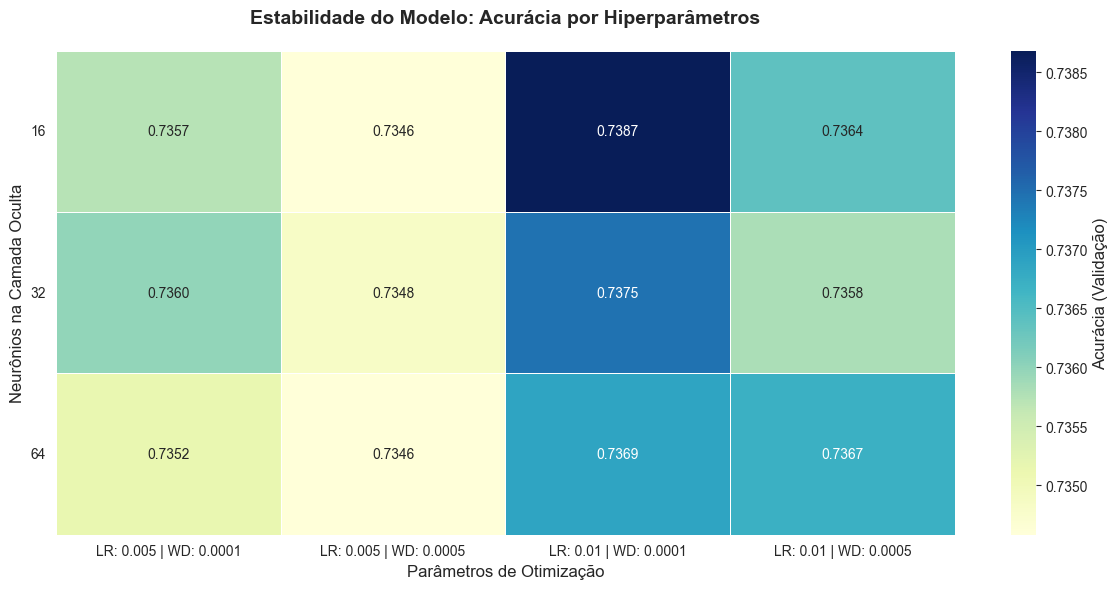

Gráfico salvo em ../outputs/figuras/heatmap_gridsearch.png


In [ ]:
# Célula: Visualização Gráfica do Grid Search (Heatmap)
import seaborn as sns
import matplotlib.pyplot as plt

# Garante que temos o dataframe (caso tenha fechado a sessão)
# df_results = pd.DataFrame(resultados) # Já existe da célula anterior

# 1. Preparação dos Dados para o Gráfico
# Vamos combinar LR e Weight Decay em uma única string para o eixo X ficar legível
df_results['Params (LR / Decay)'] = df_results.apply(
    lambda x: f"LR: {x['lr']} | WD: {x['weight_decay']}", axis=1
)

# Criamos uma matriz pivô: 
# Linhas = Neurônios (Hidden Channels)
# Colunas = Configuração de Aprendizado (LR + Decay)
# Valores = Acurácia
pivot_table = df_results.pivot(
    index='hidden_channels', 
    columns='Params (LR / Decay)', 
    values='accuracy'
)

# 2. Plotagem do Heatmap
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Heatmap com anotações numéricas
ax = sns.heatmap(
    pivot_table, 
    annot=True,          # Escreve o valor dentro do quadrado
    fmt=".4f",           # 4 casas decimais
    cmap="YlGnBu",       # Cor: Amarelo (baixo) -> Verde -> Azul (alto)
    cbar_kws={'label': 'Acurácia (Validação)'},
    linewidths=.5
)

plt.title('Estabilidade do Modelo: Acurácia por Hiperparâmetros', fontsize=14, weight='bold', pad=20)
plt.ylabel('Neurônios na Camada Oculta', fontsize=12)
plt.xlabel('Parâmetros de Otimização', fontsize=12)
plt.yticks(rotation=0) # Deixa o eixo Y reto

plt.tight_layout()
plt.savefig("../outputs/figuras/heatmap_gridsearch.png", dpi=300)
plt.show()

print("Gráfico salvo em ../outputs/figuras/heatmap_gridsearch.png")

In [25]:
# 1. Definir a Arquitetura da Rede Neural
class StreetClassifier(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        # Primeira camada de convolução (olha vizinhos imediatos)
        self.conv1 = GCNConv(num_features, 16)
        # Segunda camada (olha vizinhos dos vizinhos)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Camada 1 + Ativação ReLU
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training) # Evita decorar dados (overfitting)

        # Camada 2
        x = self.conv2(x, edge_index)

        # Saída: Probabilidade de ser cada classe (Log Softmax)
        return F.log_softmax(x, dim=1)

# 2. Inicializar
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = StreetClassifier(num_features=2, num_classes=len(classes_validas)).to(device) # fixo
# AGORA DEVE SER DINÂMICO:
num_features_input = data.num_node_features # O PyG calcula sozinho baseado no tensor x
model = StreetClassifier(num_features=num_features_input, num_classes=len(classes_validas)).to(device)
#
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

print("Iniciando treinamento (Isso pode levar alguns segundos)...")

# 3. Loop de Treinamento
model.train()
for epoch in range(200): # 200 épocas (passadas)
    optimizer.zero_grad()
    out = model(data)
    
    # Calcula erro apenas nas ruas conhecidas (Train Mask)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print(f"Época {epoch}: Erro (Loss) = {loss.item():.4f}")

print("Treinamento Concluído!")

Iniciando treinamento (Isso pode levar alguns segundos)...
Época 0: Erro (Loss) = 2.7236
Época 20: Erro (Loss) = 1.2710
Época 40: Erro (Loss) = 1.0385
Época 60: Erro (Loss) = 0.9814
Época 80: Erro (Loss) = 0.9536
Época 100: Erro (Loss) = 0.9396
Época 120: Erro (Loss) = 0.9360
Época 140: Erro (Loss) = 0.9280
Época 160: Erro (Loss) = 0.9238
Época 180: Erro (Loss) = 0.9185
Treinamento Concluído!


## Predição e Exportação

In [ ]:
model.eval() # Modo de avaliação
_, pred = model(data).max(dim=1) # Pega a classe com maior probabilidade

# Recupera os nomes das classes (número -> texto)
pred_classes = le.inverse_transform(pred.cpu().numpy())

# Atualiza o GeoDataFrame
print("Aplicando predições...")

# Cria coluna nova
road_gdf['class_gnn'] = road_gdf['class']

# Onde era desconhecido (predict_mask), coloca o valor predito
mask_np = data.predict_mask.cpu().numpy()
road_gdf.loc[mask_np, 'class_gnn'] = pred_classes[mask_np]

# Substitui a coluna oficial para usarmos no cálculo de velocidade
road_gdf['class'] = road_gdf['class_gnn']

print("Classificação via GNN finalizada.")
print("\nExemplo de ruas 'unclassified' que foram classificadas:")

# --- AJUSTE AQUI (Nome da coluna corrigido para 'length_norm') ---
# Verificamos quais colunas existem para evitar erro
cols_para_ver = ['id', 'length_norm', 'classe_original','class_gnn']
# Se por acaso 'length_norm' não existir, tenta 'length' ou 'len_norm'
if 'length_norm' not in road_gdf.columns:
    if 'length_norm' in road_gdf.columns:
        cols_para_ver[1] = 'length_norm'
    elif 'length' in road_gdf.columns:
         cols_para_ver[1] = 'length'

print(road_gdf[mask_np][cols_para_ver].head(10))

Aplicando predições...
Classificação via GNN finalizada.

Exemplo de ruas 'unclassified' que foram classificadas:
                                     id       length classe_original  \
0  6d775c41-5cf2-493e-b402-cfcbd8972262   720.449364    unclassified   
1  aec4047f-e9b3-4c2b-ba48-c1c065ffc97e  2081.823556    unclassified   
2  fabe85df-cfbc-4adc-a6e7-7a41c44f39c6  1099.216268    unclassified   
3  7b0e2bea-3908-4ba4-93da-6f9ff6f06056   540.386635    unclassified   
4  87309c7e-7195-4237-9d45-42570008a3b4   665.671536    unclassified   
5  4797c7d7-c1bf-4919-95c9-b5a036922ae0   973.132207    unclassified   
6  7327becf-7849-420c-84dc-a397faeafc76    57.470799    unclassified   
7  31516b8b-452e-44cc-8a4d-914b0a0bfe5d  3354.665865    unclassified   
8  03066505-ac3f-4fe4-bff6-7ca75579a32f  1468.727184    unclassified   
9  1adc41b1-2057-4f0c-9234-19a8b2a248b9    97.219294    unclassified   

     class_gnn  
0  residential  
1     tertiary  
2  residential  
3     tertiary  
4     te

In [27]:
# Define qual coluna queremos analisar
coluna_alvo = 'class_gnn'

if coluna_alvo in road_gdf.columns:
    print(f"\n--- Distribuição de Trechos por Classe ('{coluna_alvo}') ---")
    
    # value_counts(dropna=False) conta inclusive os nulos (se houver)
    # O resultado já vem ordenado do maior para o menor
    contagem = road_gdf[coluna_alvo].value_counts(dropna=False)
    total_segmentos = len(road_gdf)
    total_classes = len(road_gdf["class_gnn"].unique().tolist())

    # Iterar sobre a série para imprimir formatado
    for classe, qtd in contagem.items():
        percentual = (qtd / total_segmentos) * 100
        # O :<20 garante alinhamento do texto à esquerda
        print(f"  • {str(classe):<20}: {qtd:,} trechos ({percentual:.1f}%)")
        
    print(f"\n - Total de Segmentos: {total_segmentos:,}")
    print(f" - Total de Classes: {total_classes:,}")

else:
    print(f"Erro: A coluna '{coluna_alvo}' não existe no DataFrame.")


--- Distribuição de Trechos por Classe ('class_gnn') ---
  • residential         : 49,204 trechos (74.1%)
  • tertiary            : 5,227 trechos (7.9%)
  • secondary           : 3,436 trechos (5.2%)
  • service             : 2,956 trechos (4.4%)
  • primary             : 2,571 trechos (3.9%)
  • trunk               : 845 trechos (1.3%)
  • living_street       : 662 trechos (1.0%)
  • path                : 527 trechos (0.8%)
  • footway             : 499 trechos (0.8%)
  • track               : 491 trechos (0.7%)
  • pedestrian          : 26 trechos (0.0%)

 - Total de Segmentos: 66,444
 - Total de Classes: 11


### 4 Teste Estatísitco

Gerando estatísticas de validação...


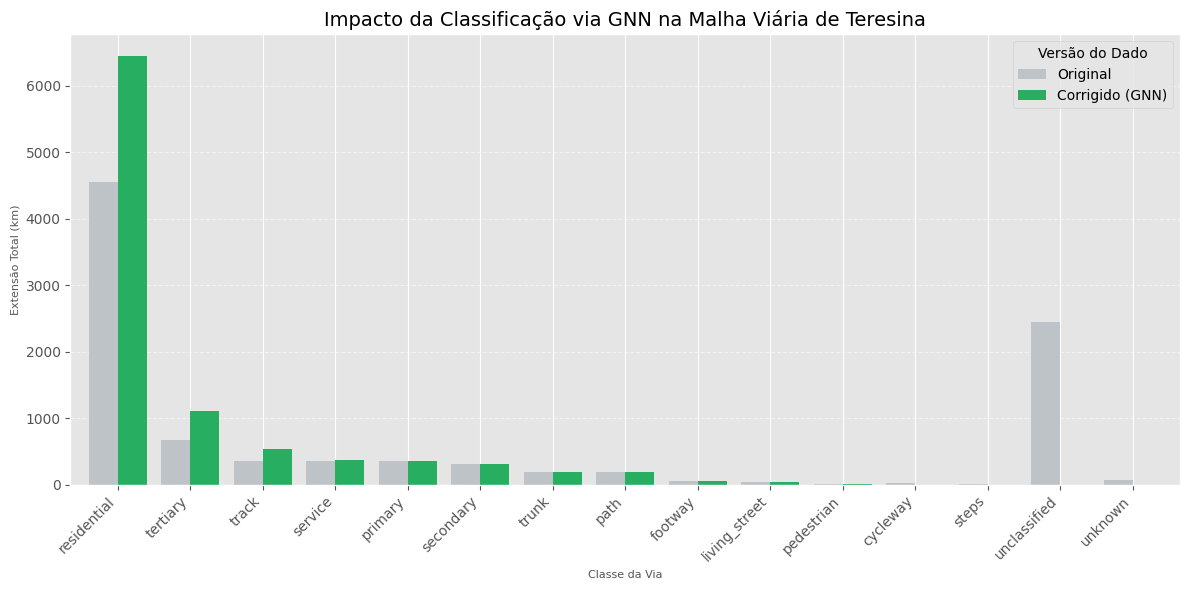

Gráfico salvo em ../outputs/figuras/validacao_classes.png

--- RESUMO DA MUDANÇA (em KM) ---
residential     1898.882972
tertiary         432.692923
track            188.659923
service           16.068734
cycleway         -29.735894
steps             -0.484185
unclassified   -2443.874374
unknown          -62.210099
dtype: float64


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("Gerando estatísticas de validação...")

# 1. Preparar dados para comparação
# Vamos somar a quilometragem por classe (mais relevante que contagem de linhas)
stats_antes = road_gdf.groupby('classe_original')['length'].sum() / 1000 # em KM
stats_depois = road_gdf.groupby('class_gnn')['length'].sum() / 1000       # em KM

# Cria um DataFrame único para plotagem
df_stats = pd.DataFrame({'Original': stats_antes, 'Corrigido (GNN)': stats_depois}).fillna(0)

# Ordena para ficar bonito no gráfico (do maior para o menor no corrigido)
df_stats = df_stats.sort_values(by='Corrigido (GNN)', ascending=False)

# 2. Visualização Gráfica
fig, ax = plt.subplots(figsize=(12, 6))

df_stats.plot(kind='bar', ax=ax, width=0.8, color=['#bdc3c7', '#27ae60'])

plt.title("Impacto da Classificação via GNN na Malha Viária de Teresina", fontsize=14)
plt.ylabel("Extensão Total (km)", fontsize=8)
plt.xlabel("Classe da Via", fontsize=8)
plt.legend(title="Versão do Dado")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig("../outputs/figuras/validacao_classes.png", dpi=300)
plt.show()

print("Gráfico salvo em ../outputs/figuras/validacao_classes.png")

# 3. Printar números absolutos para você citar no texto
print("\n--- RESUMO DA MUDANÇA (em KM) ---")
diff = df_stats['Corrigido (GNN)'] - df_stats['Original']
print(diff[diff != 0]) # Mostra apenas o que mudou

In [29]:
road_gdf.to_file("../dados/processados/overturemaps/teresina_bbox_GNN.gpkg", layer="teresina_bbox_GNN", driver="GPKG")

# PAREI AQUI OU CONTINUAR DAQUI

<Axes: >

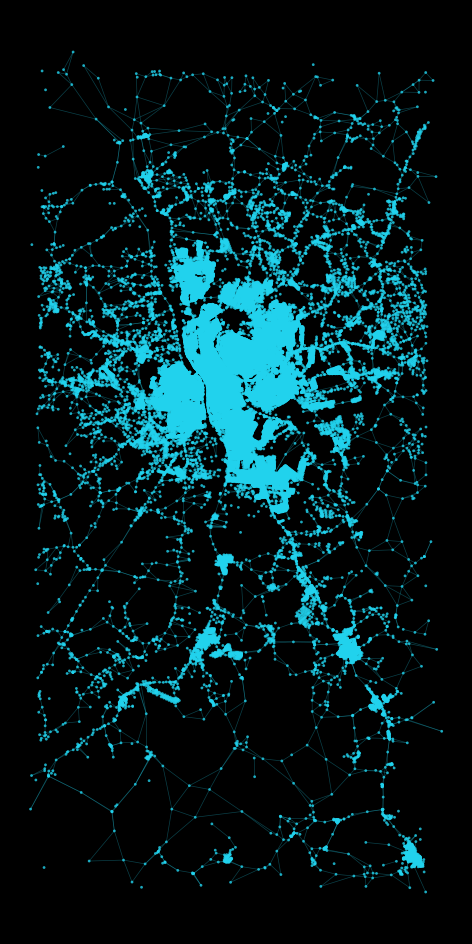

In [35]:
c2g.plot_graph(G_dual)